In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import utility
import torch.nn.functional as F
from leaptorch import Projector
from soft_dtw_triton import SoftDTWTriton

In [2]:
v_scale = 8 # config['dataset']['v_scale'] # view binning. 8이라면 세로 축이 8배로 줄어듦. (sparse view 용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

view = 512
det = 768 #config['model']['ct']['num_det'] # detector num. 736
down_view = view // v_scale # 512 // 8 -> 64
det_interval = 0.72
recon_interval = 0.75

In [3]:
gt = torch.from_numpy(np.load("gt.npy"))
sinogram = torch.from_numpy(np.load("sinogram.npy")).unsqueeze(0).unsqueeze(2)

In [4]:
# preparation
backproj = Projector(
    forward_project=False,
    use_static=True,
    use_gpu=torch.cuda.is_available(),
    gpu_device=torch.device(0),
    batch_size=1
)

backproj.set_parallelbeam(
    view, 
    1, # detector row size
    det, 
    1, 
    det_interval,
    0, 
    0.5 * (det - 1),
    np.linspace(0, 180, view, endpoint = False, dtype='float32'),
)

sino_filtered = backproj.leapct.rampFilterProjections(sinogram.cuda()) / 2 / np.pi # ramp filtering

In [5]:
backproj.set_parallelbeam(
    down_view, 
    1, # detector row size
    det, 
    1, 
    det_interval,
    0, 
    0.5 * (det - 1),
    np.linspace(0, 180, down_view, endpoint = False, dtype='float32'),
)
backproj.set_volume(
    512, # reconstruction size: x
    512, # reconstruction size: y
    1, # reconstruction size: z
    voxelWidth=recon_interval,
    voxelHeight=1
)
backproj.allocate_batch_data()

u_water = 0.0192867
sino_sparse = sino_filtered[:, ::v_scale, :, :]
recon_sparse = backproj(sino_sparse.contiguous()) / sino_sparse.shape[1] * det_interval * np.pi / recon_interval ** 2
recon_sparse = recon_sparse * 1000 / u_water

sino_filtered, sino_sparse = sino_filtered.permute(0, 2, 1, 3), sino_sparse.permute(0, 2, 1, 3)
print(sino_filtered.shape, sino_sparse.shape)

torch.Size([1, 1, 512, 768]) torch.Size([1, 1, 64, 768])


In [6]:
backproj.set_parallelbeam( # [up_view, ch, det, 1] 이런 식으로 들어가기 때문에 shape 나중에 주의.
    view, 
    1, 
    det, 
    1, 
    det_interval,
    0, 
    0.5 * (det - 1),
    np.linspace(0, 180, view, endpoint = False, dtype='float32'),
)
backproj.allocate_batch_data()

sino_coord = utility.make_coord((view, det), torch.device('cuda'))
sino_coord[:, :, :, 1] += (view // down_view - 1) / view

sino_naive = F.grid_sample(sino_sparse, sino_coord, mode='bilinear', padding_mode='border', align_corners=False).permute(0, 2, 1, 3)
recon_naive = backproj(sino_naive.contiguous()) / sino_naive.shape[1] * det_interval * np.pi / recon_interval ** 2
recon_naive = recon_naive * 1000 / u_water

sdtw = SoftDTWTriton(gamma=1e-4)
sino_shift = torch.roll(sino_sparse, shifts=(1, 0), dims=(2, 3))
sino_shift[:, :, 0, :] = sino_shift[:, :, 0, :].flip(-1)

E = sdtw(sino_sparse.view(-1, det, 1).contiguous(), sino_shift.view(-1, det, 1).contiguous(), bandwidth=32)
det_idx = torch.arange(det).cuda()
# tangent_down = (((E * det_idx.view(1,-1,1)).sum(1) / E.sum(1)) - det_idx).view(1, 1, down_view, -1)
# tangent_up = (((E * det_idx.view(1,1,-1)).sum(2) / E.sum(2)) - det_idx).view(1, 1, down_view, -1)
tangent_down = ((E.argmax(1)) - det_idx).view(1, 1, down_view, -1)
tangent_up = ((E.argmax(2)) - det_idx).view(1, 1, down_view, -1)

tangent_dtw = (tangent_up - tangent_down) / 2
tangent_dtw = F.grid_sample(tangent_dtw, sino_coord, mode='bilinear', padding_mode='border', align_corners=False)

sino_dtw = utility.grid_sample_slope(sino_sparse, sino_coord, tangent_dtw).view(1, view, 1, det)
recon_dtw = backproj(sino_dtw.contiguous()) / sino_dtw.shape[1] * det_interval * np.pi / recon_interval ** 2
recon_dtw = recon_dtw * 1000 / u_water

PSNR for sparse recon: 26.961543560028076
PSNR for naive recon: 30.597546100616455
PSNR for DTW recon: 35.50096035003662


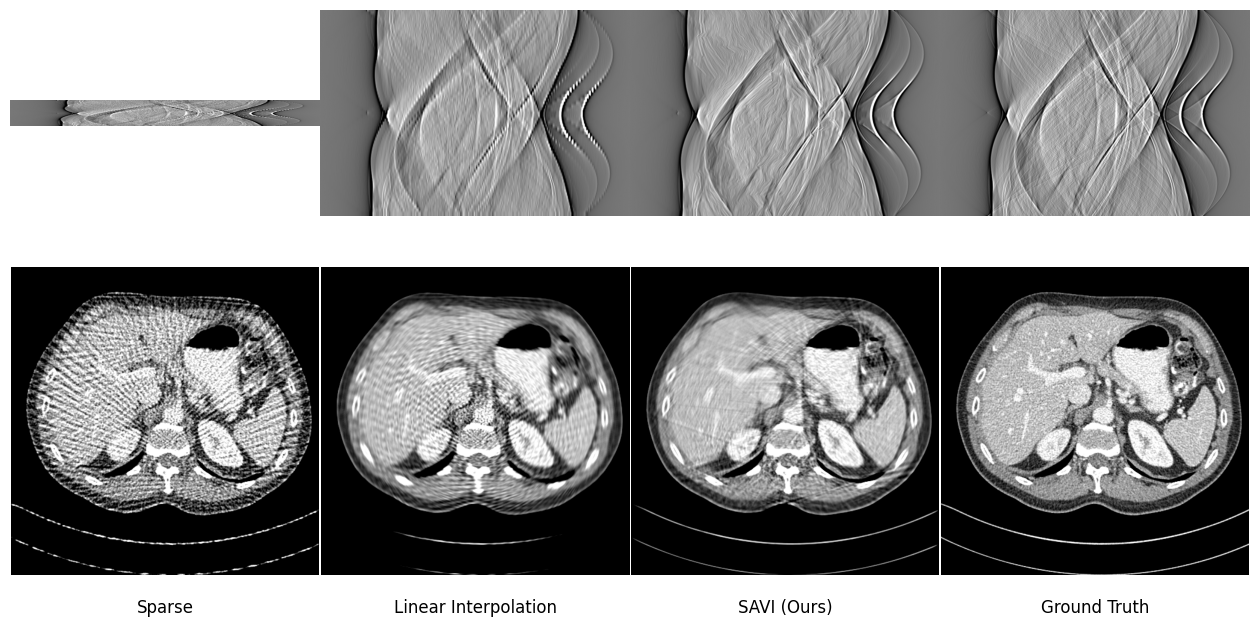

In [15]:
print("PSNR for sparse recon: {}".format(20 * torch.log10(gt.max() / torch.sqrt(torch.mean((recon_sparse.squeeze().cpu() - gt) ** 2))).item()))
print("PSNR for naive recon: {}".format(20 * torch.log10(gt.max() / torch.sqrt(torch.mean((recon_naive.squeeze().cpu() - gt) ** 2))).item()))
print("PSNR for DTW recon: {}".format(20 * torch.log10(gt.max() / torch.sqrt(torch.mean((recon_dtw.squeeze().cpu() - gt) ** 2))).item()))

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Define titles for the subplots
titles = ["Sparse", "Linear Interpolation", "SAVI (Ours)", "Ground Truth"]

# Plotting Sinograms
axs[0, 0].imshow(sino_sparse[0, 0, :, :].cpu(), cmap='gray', vmin=-0.03, vmax=0.03)
axs[0, 1].imshow(sino_naive[0, :, 0, :].cpu(), cmap='gray', vmin=-0.03, vmax=0.03)
axs[0, 2].imshow(sino_dtw[0, :, 0, :].cpu(), cmap='gray', vmin=-0.03, vmax=0.03)
axs[0, 3].imshow(sino_filtered[0, 0, :, :].cpu(), cmap='gray', vmin=-0.03, vmax=0.03)

# Plotting Reconstructions
axs[1, 0].imshow(recon_sparse[0, 0, :, :].cpu() - 1024, cmap='gray', vmin=-180, vmax=240)
axs[1, 1].imshow(recon_naive[0, 0, :, :].cpu() - 1024, cmap='gray', vmin=-180, vmax=240)
axs[1, 2].imshow(recon_dtw[0, 0, :, :].cpu() - 1024, cmap='gray', vmin=-180, vmax=240)
axs[1, 3].imshow(gt[:, :].cpu() - 1024, cmap='gray', vmin=-180, vmax=240)

# Set captions at the bottom and remove axes
for j in range(4):
    axs[0, j].axis('off')
    axs[1, j].set_title(titles[j], y=-0.15)
    axs[1, j].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()